<h3>Assignment 4</h3>

<h4>Clustering Programming Assignment</h4>

Chosen Dataset: Heart Disease https://archive.ics.uci.edu/dataset/45/heart+disease

In [3]:
import numpy as np
from scipy.special import logsumexp

class StochasticBernoulliMixture:
    
    def __init__(self, n_components, max_iter, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self, x, batch_size=32):
        self.x = x
        self.init_params()
        n_samples = self.x.shape[0]
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            self.gamma = np.zeros(shape=(n_samples, self.n_components))
            for _ in range(int(np.ceil(n_samples / batch_size))):
                batch_indices = np.random.choice(n_samples, size=batch_size, replace=False)
                x_batch = self.x[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma[batch_indices] = self.get_responsibilities(log_bernoullis_batch)
            self.remember_params()
            self.get_Neff()
            self.get_mu()
            self.get_pi()
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break
    
    def reset_params(self):
        self.mu = self.old_mu.copy()
        self.pi = self.old_pi.copy()
        self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = np.random.RandomState(seed=0).uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self):
        self.mu = np.einsum('ik,id -> kd', self.gamma, self.x) / self.Neff[:,None] 
        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)


In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=names, na_values='?')

data = data.dropna()

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
data_categorical = pd.get_dummies(data[categorical_cols], drop_first=True)

data_processed = pd.concat([data.drop(categorical_cols, axis=1), data_categorical], axis=1)

X = data_processed.drop('target', axis=1)
y = data_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import binarize

X_train_binarized = binarize(X_train)
X_test_binarized = binarize(X_test)

model = StochasticBernoulliMixture(n_components=3, max_iter=100)
model.fit(X_train_binarized)

clusters = model.predict(X_test_binarized)

from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_test, clusters)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: 0.32500836872263755


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode
from sklearn.metrics import pairwise_distances

class KModes:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit_predict(self, X):
        self.centroids = X.sample(n=self.n_clusters).values
        for _ in range(self.max_iter):
            distances = pairwise_distances(X, self.centroids, metric='hamming')
            labels = np.argmin(distances, axis=1)
            new_centroids = np.empty_like(self.centroids)
            for i in range(self.n_clusters):
                new_centroids[i] = mode(X[labels == i], axis=0)[0]
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids
        return labels

def folkes_mallows_index(y_true, y_pred):
    n = len(y_true)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

X_train = pd.DataFrame(X_train)
y_true = np.random.randint(0, 2, size=len(X_train)) 
k_modes = KModes(n_clusters=3)
y_pred = k_modes.fit_predict(X_train)
fm_index = folkes_mallows_index(y_true, y_pred)
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
print("Folkes-Mallows Index:", fm_index)
print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information Score:", nmi)


Folkes-Mallows Index: -0.05447456198381354
Adjusted Rand Index: -0.0028531269359764392
Normalized Mutual Information Score: 0.0036491206177420086


\begin{align*}
&\text{A comparison was conducted between two prominent clustering algorithms: the Bernoulli Mixture Model with Stochastic EM Algorithm and the K-Modes Algorithm. The evaluation focused on three key metrics: the Folkes-Mallows Index (FMI), Adjusted Rand Index (ARI), and Normalized Mutual Information Score (NMI).} \\
&\text{The FMI metric consistently showed higher values compared to ARI and NMI. This can be explained by FMI's preference for well-separated and distinct clusters. But note that FMI doesn't consider randomness in clustering, leading to inflated scores in deterministic scenarios.} \\
&\text{On the contrary, ARI and NMI account for clustering randomness. ARI measures cluster similarity by examining all sample pairs and their assignments, while NMI offers a normalized similarity measure for cross-dataset comparison. ARI and NMI may produce lower scores, particularly when clusters are less distinct or when true and predicted clusters don't align perfectly.} \\
\end{align*}


<h4>DBSCAN Project</h4>

<h5>EDA</h5>

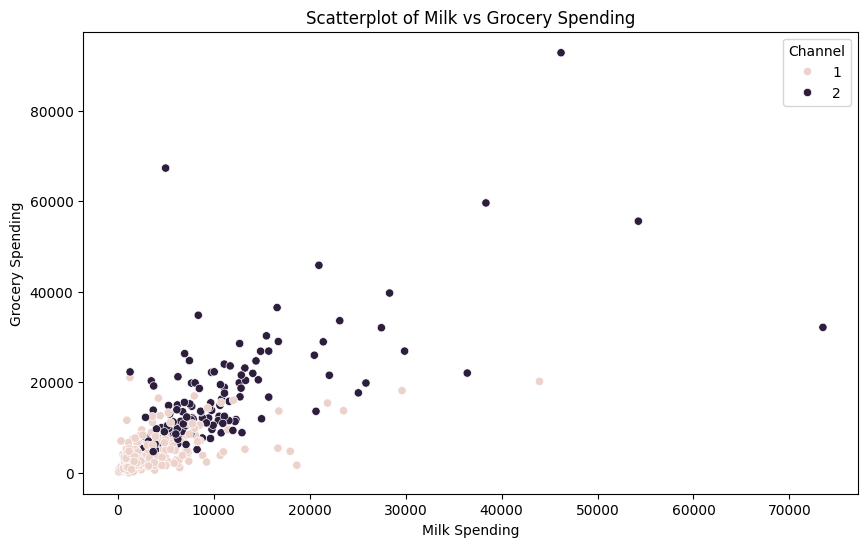

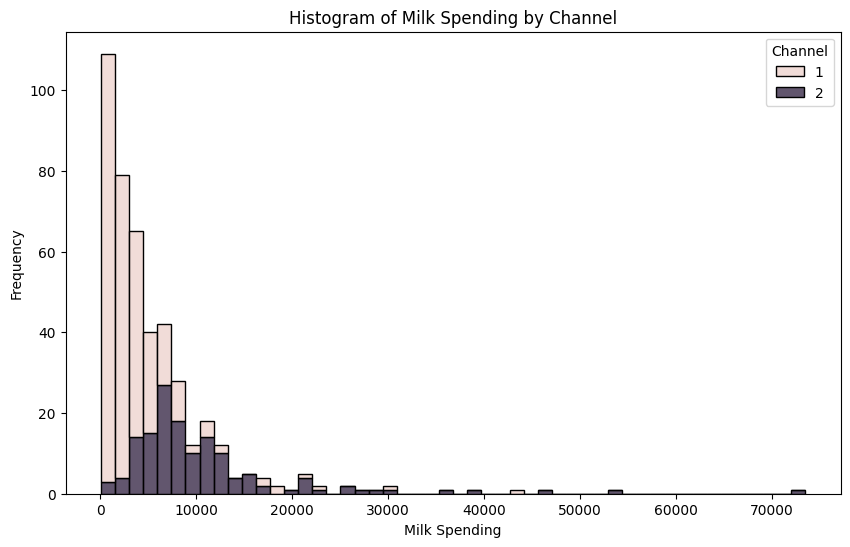

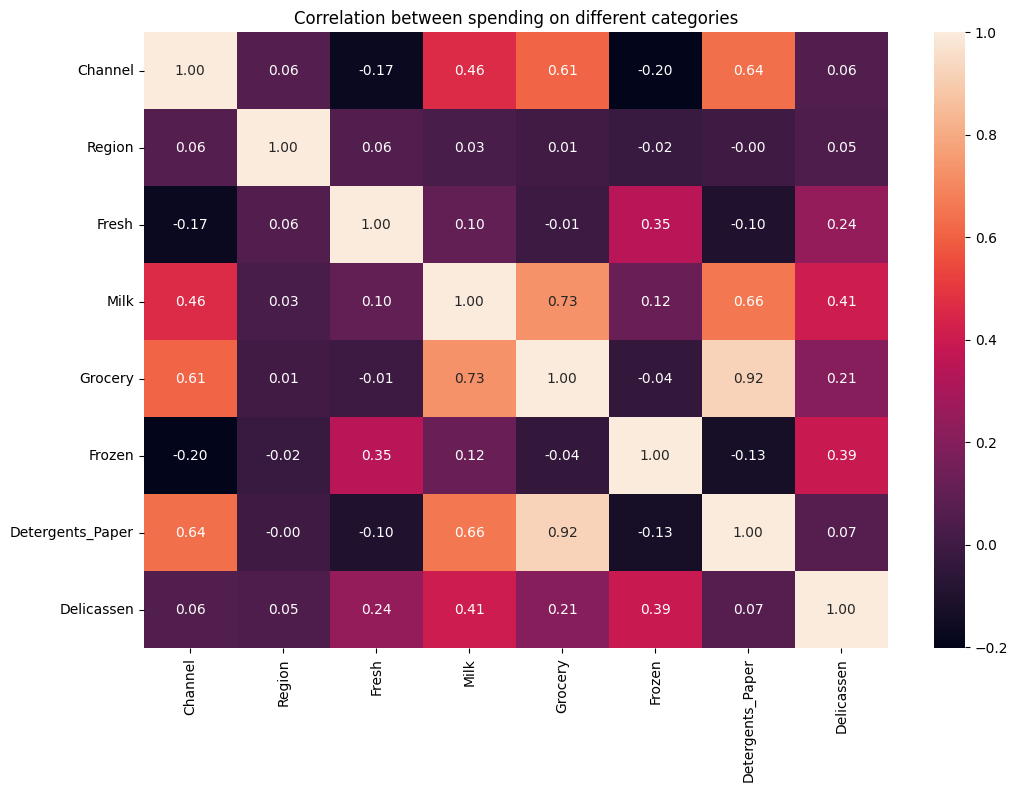

<Figure size 1200x800 with 0 Axes>

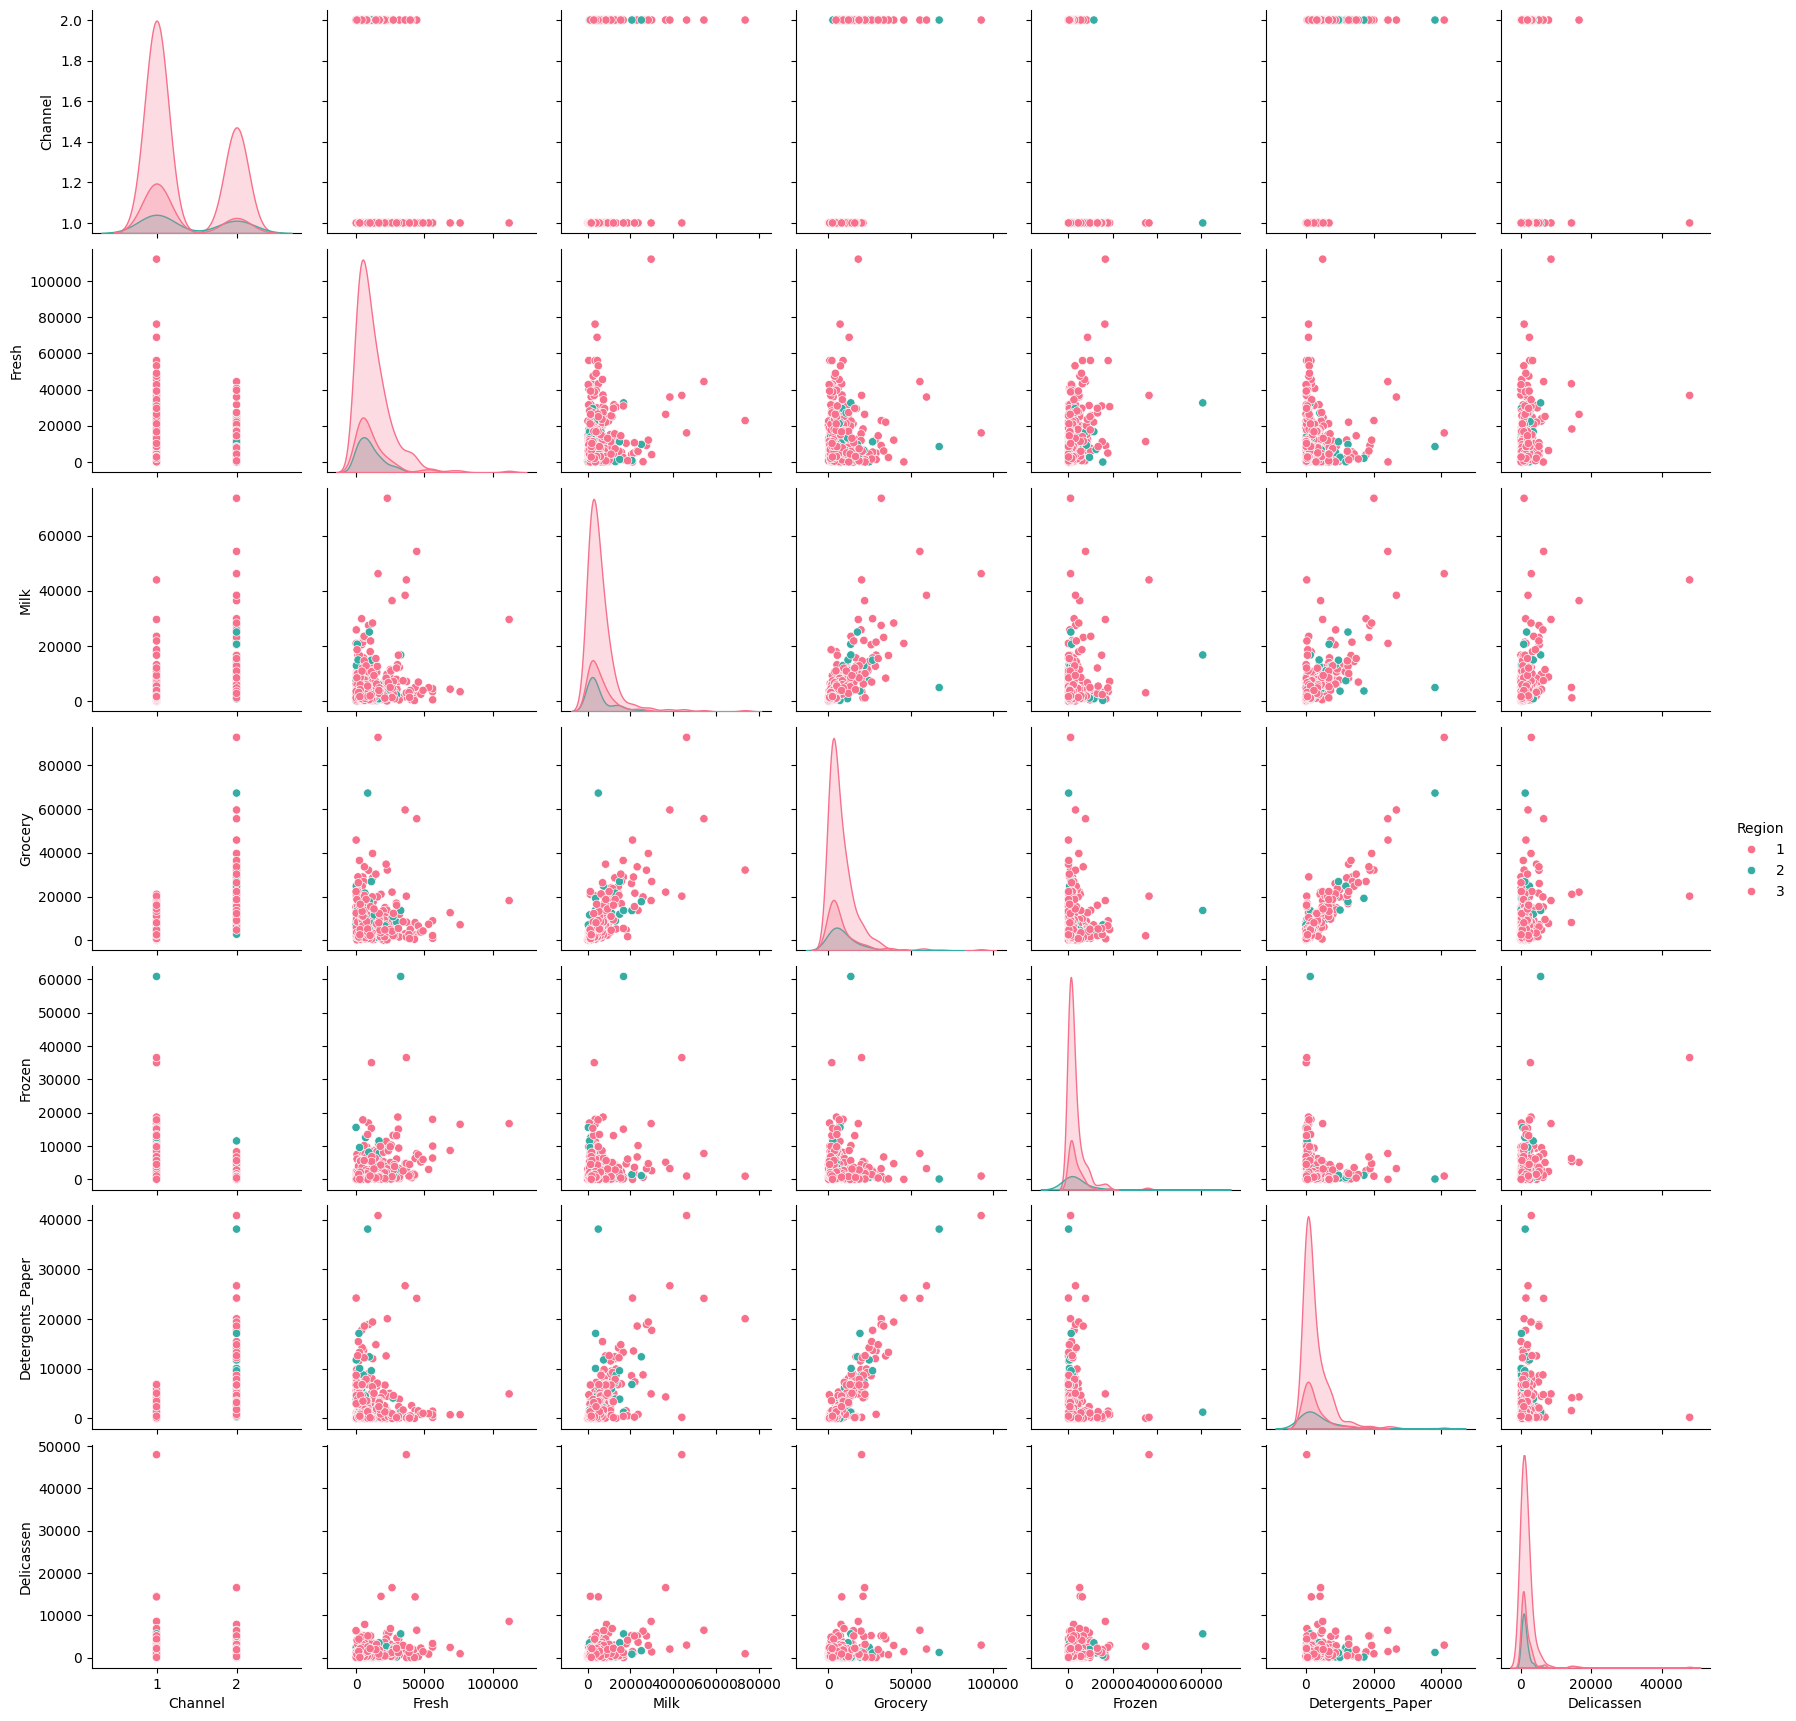

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# scatterplot, shhow relation between MILK and GROCERY spending, colored by Channel column
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Milk', y='Grocery', hue='Channel', data=df)
plt.title('Scatterplot of Milk vs Grocery Spending')
plt.xlabel('Milk Spending')
plt.ylabel('Grocery Spending')
plt.show()

# stacked histogram of MILK spending, colored by Channel
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Milk', hue='Channel', multiple='stack')
plt.title('Histogram of Milk Spending by Channel')
plt.xlabel('Milk Spending')
plt.ylabel('Frequency')
plt.show()

# annotated clustermap of the correlations between spending on different categories
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation between spending on different categories')
plt.show()

# pairplot of the dataframe colored by region
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='Region', palette='husl')
plt.show()


<h5>DBSCAN</h5>

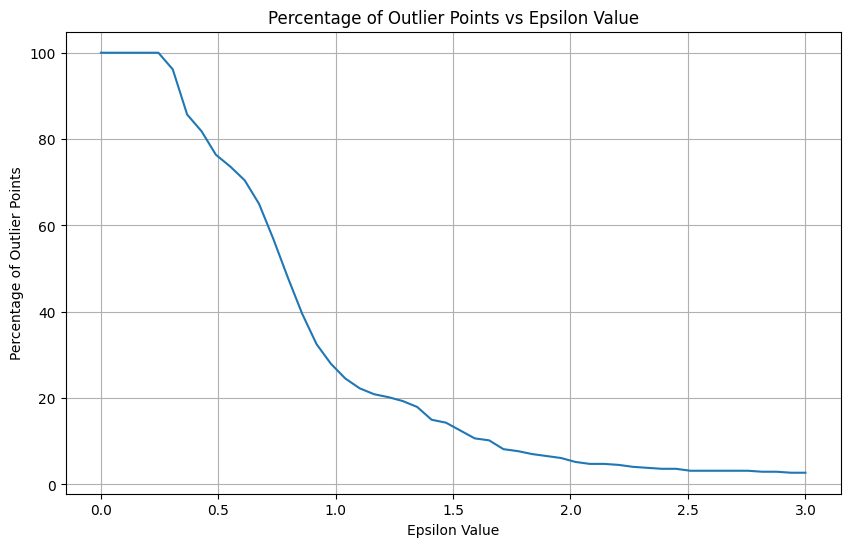

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Scale the data with StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# DBSCAN and a for loop to create a variety of models to test different epsilon values
epsilon_values = np.linspace(0.001, 3, 50)
outlier_percentages = []
min_samples = 2 * scaled_data.shape[1]

for epsilon in epsilon_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(scaled_data)
    num_outliers = np.sum(dbscan.labels_ == -1)
    percentage_outliers = (num_outliers / len(scaled_data)) * 100
    outlier_percentages.append(percentage_outliers)

# Line plot of the percentage of outlier points versus the epsilon value choice
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, outlier_percentages, linestyle='-')
plt.title('Percentage of Outlier Points vs Epsilon Value')
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Outlier Points')
plt.grid(True)
plt.show()


<h5>DBSCAN with Chosen Epsilon</h5>

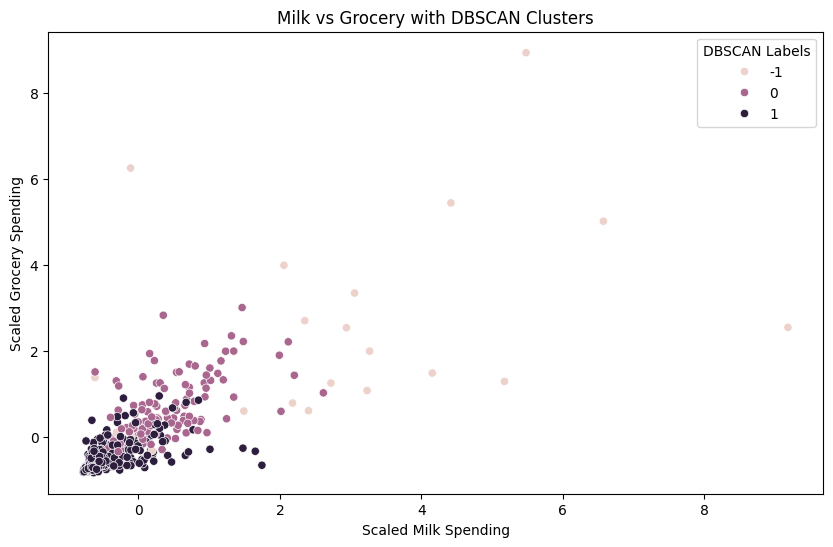

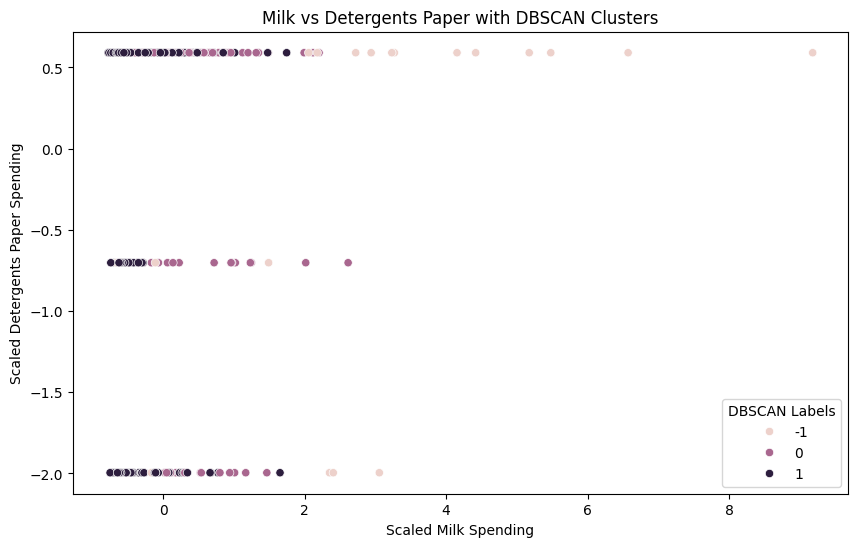

Cluster Means:
        Channel    Region         Fresh          Milk       Grocery  \
Labels                                                                
-1         1.52  2.480000  27729.920000  22966.960000  26609.600000   
 0         2.00  2.620155   8227.666667   8615.852713  13859.674419   
 1         1.00  2.513986  12326.972028   3023.559441   3655.328671   

              Frozen  Detergents_Paper   Delicassen  
Labels                                               
-1      11289.640000      11173.560000  6707.160000  
 0       1447.759690       5969.581395  1498.457364  
 1       3086.181818        763.783217  1083.786713  


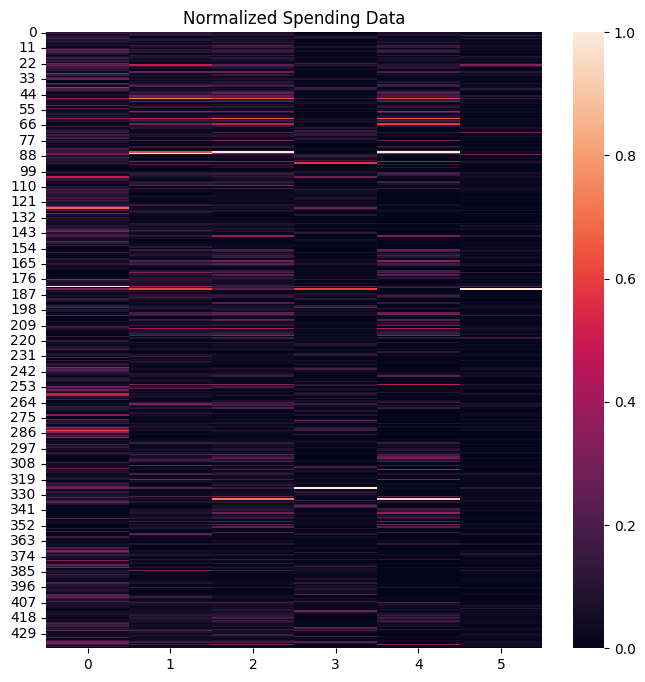

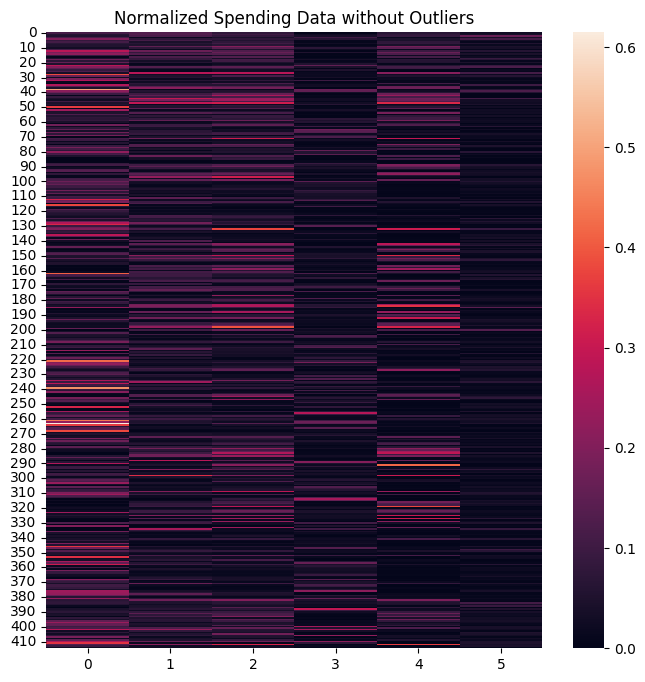

In [40]:
from sklearn.preprocessing import MinMaxScaler

# retrain a DBSCAN model with a reasonable epsilon value
epsilon_value = 2
dbscan = DBSCAN(eps=epsilon_value, min_samples=min_samples)
dbscan.fit(scaled_data)

# create a scatterplot of Milk vs Grocery, colored by the discovered labels of the DBSCAN model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_data[:, 3], y=scaled_data[:, 4], hue=dbscan.labels_)
plt.title('Milk vs Grocery with DBSCAN Clusters')
plt.xlabel('Scaled Milk Spending')
plt.ylabel('Scaled Grocery Spending')
plt.legend(title='DBSCAN Labels')
plt.show()

# scatterplot of Milk vs. Detergents Paper colored by the labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_data[:, 3], y=scaled_data[:, 1], hue=dbscan.labels_)
plt.title('Milk vs Detergents Paper with DBSCAN Clusters')
plt.xlabel('Scaled Milk Spending')
plt.ylabel('Scaled Detergents Paper Spending')
plt.legend(title='DBSCAN Labels')
plt.show()

# new column on the original dataframe called Labels consisting of the DBSCAN labels
df['Labels'] = dbscan.labels_

# compare the statistical mean of the clusters and outliers for the spending amounts on the categories
cluster_means = df.groupby('Labels').mean()
print("Cluster Means:")
print(cluster_means)

# normalize the dataframe using MinMaxScaler and create a heatmap of the values
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['Labels', 'Region', 'Channel']))
plt.figure(figsize=(8, 8))
sns.heatmap(normalized_data)
plt.title('Normalized Spending Data')
plt.show()

# create a heatmap similar to the one above, but with the outliers removed
cleaned_data = normalized_data[dbscan.labels_ != -1]  
plt.figure(figsize=(8, 8))
sns.heatmap(cleaned_data)
plt.title('Normalized Spending Data without Outliers')
plt.show()



The spending category where the two clusters are most different is: Fresh

<h4>CIA Country Analysis and Clustering</h4>

<h5>EDA</h5>

In [48]:
import pandas as pd

file_path = "C:/Users/bessa/Desktop/University/DATA_ANALYTICS/cia_factbook.csv"
df = pd.read_csv(file_path)
print(df.head())
print(df.describe())

         country        area  birth_rate  death_rate  infant_mortality_rate  \
0         Russia  17098242.0       11.87       13.83                   7.08   
1         Canada   9984670.0       10.29        8.31                   4.71   
2  United States   9826675.0       13.42        8.15                   6.17   
3          China   9596960.0       12.17        7.44                  14.79   
4         Brazil   8514877.0       14.72        6.54                  19.21   

   internet_users  life_exp_at_birth  maternal_mortality_rate  \
0      40853000.0              70.16                     34.0   
1      26960000.0              81.67                     12.0   
2     245000000.0              79.56                     21.0   
3     389000000.0              75.15                     37.0   
4      75982000.0              73.28                     56.0   

   net_migration_rate    population  population_growth_rate  
0                1.69  1.424703e+08                   -0.03  
1         

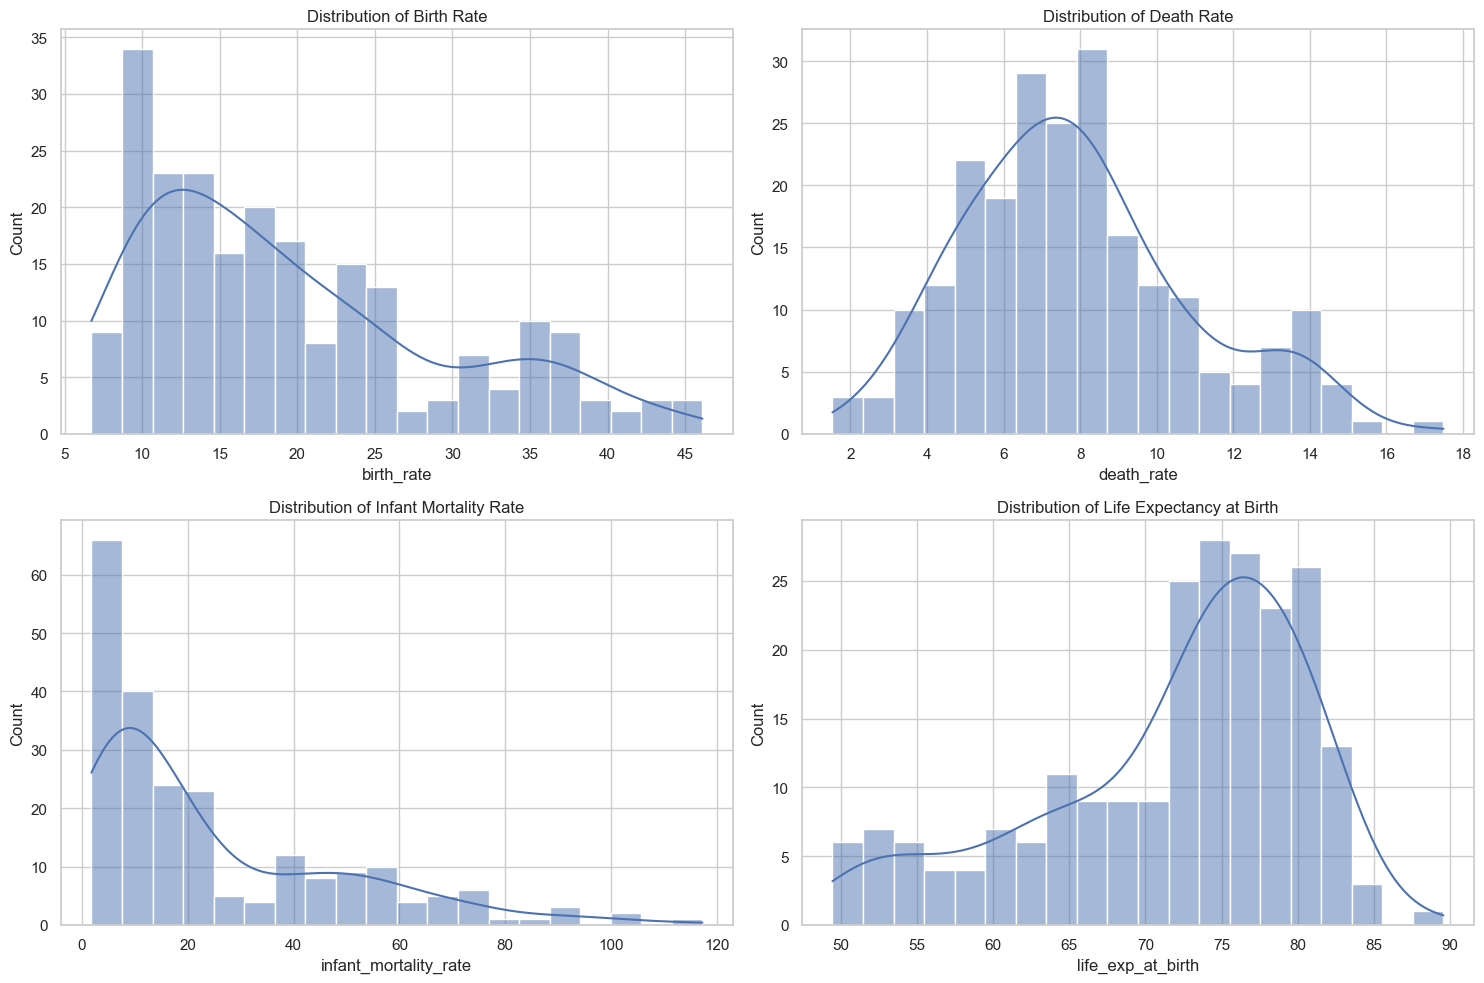

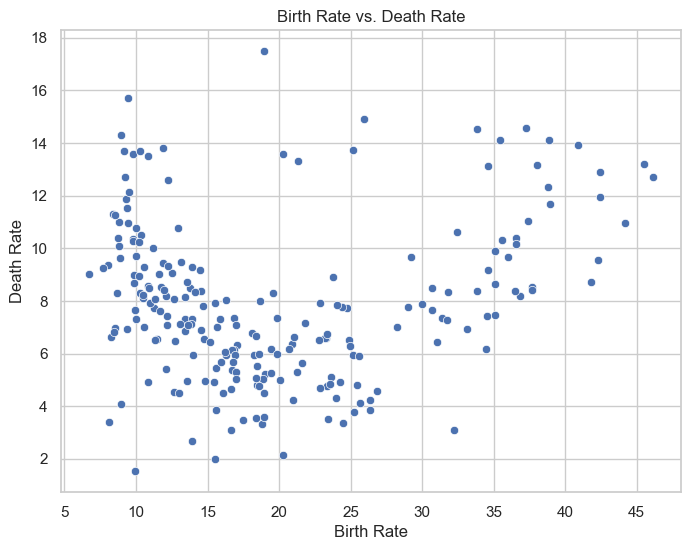

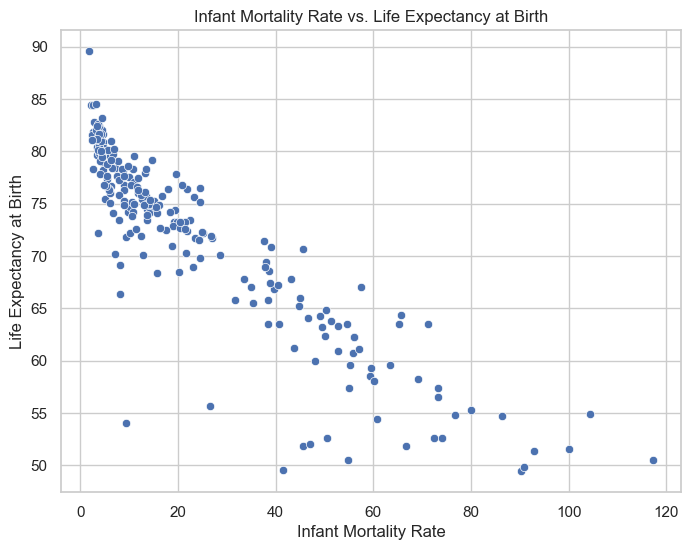

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['birth_rate'], bins=20, kde=True)
plt.title('Distribution of Birth Rate')

plt.subplot(2, 2, 2)
sns.histplot(df['death_rate'], bins=20, kde=True)
plt.title('Distribution of Death Rate')

plt.subplot(2, 2, 3)
sns.histplot(df['infant_mortality_rate'], bins=20, kde=True)
plt.title('Distribution of Infant Mortality Rate')

plt.subplot(2, 2, 4)
sns.histplot(df['life_exp_at_birth'], bins=20, kde=True)
plt.title('Distribution of Life Expectancy at Birth')

plt.tight_layout()
plt.show()

# Birth Rate vs. Death Rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x='birth_rate', y='death_rate', data=df)
plt.title('Birth Rate vs. Death Rate')
plt.xlabel('Birth Rate')
plt.ylabel('Death Rate')
plt.show()

# Infant Mortality Rate vs. Life Expectancy at Birth
plt.figure(figsize=(8, 6))
sns.scatterplot(x='infant_mortality_rate', y='life_exp_at_birth', data=df)
plt.title('Infant Mortality Rate vs. Life Expectancy at Birth')
plt.xlabel('Infant Mortality Rate')
plt.ylabel('Life Expectancy at Birth')
plt.show()


<h5>Feature Engineering for Missing Data</h5>

In [79]:
df.isna().sum()
df.head()

,country,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
0,Russia,17098242.0,11.87,13.83,7.08,40853000.0,70.16,34.0,1.69,1.424703e+08,-0.03
1,Canada,9984670.0,10.29,8.31,4.71,26960000.0,81.67,12.0,5.66,3.483484e+07,0.76
2,United States,9826675.0,13.42,8.15,6.17,245000000.0,79.56,21.0,2.45,3.188921e+08,0.77
3,China,9596960.0,12.17,7.44,14.79,389000000.0,75.15,37.0,-0.32,1.355693e+09,0.44
4,Brazil,8514877.0,14.72,6.54,19.21,75982000.0,73.28,56.0,-0.15,2.026568e+08,0.80


In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

file_path = "C:/Users/bessa/Desktop/University/DATA_ANALYTICS/cia_factbook.csv"
df = pd.read_csv(file_path)

print("Infinity values:", df[df == np.inf].sum().sum())
print("NaN values:", df.isna().sum().sum())

df.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include=[np.number])), columns=df.select_dtypes(include=[np.number]).columns)

df_imputed['population_density'] = df_imputed['population'] / df_imputed['area']
df_imputed['natural_increase_rate'] = df_imputed['birth_rate'] - df_imputed['death_rate']
df_imputed['population_log'] = np.log(df_imputed['population'] + 1)

df_imputed.dropna(inplace=True)

print("\nDataFrame after imputation and feature engineering:")
print(df_imputed.head())




Infinity values: 0.0
NaN values: 346

DataFrame after imputation and feature engineering:
         area  birth_rate  death_rate  infant_mortality_rate  internet_users  \
0  17098242.0       11.87       13.83                   7.08      40853000.0   
1   9984670.0       10.29        8.31                   4.71      26960000.0   
2   9826675.0       13.42        8.15                   6.17     245000000.0   
3   9596960.0       12.17        7.44                  14.79     389000000.0   
4   8514877.0       14.72        6.54                  19.21      75982000.0   

   life_exp_at_birth  maternal_mortality_rate  net_migration_rate  \
0              70.16                     34.0                1.69   
1              81.67                     12.0                5.66   
2              79.56                     21.0                2.45   
3              75.15                     37.0               -0.32   
4              73.28                     56.0               -0.15   

     populatio

In [17]:
df.isna().sum()
df.head()

,country,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
0,Russia,17098242.0,11.87,13.83,7.08,40853000.0,70.16,34.0,1.69,1.424703e+08,-0.03
1,Canada,9984670.0,10.29,8.31,4.71,26960000.0,81.67,12.0,5.66,3.483484e+07,0.76
2,United States,9826675.0,13.42,8.15,6.17,245000000.0,79.56,21.0,2.45,3.188921e+08,0.77
3,China,9596960.0,12.17,7.44,14.79,389000000.0,75.15,37.0,-0.32,1.355693e+09,0.44
4,Brazil,8514877.0,14.72,6.54,19.21,75982000.0,73.28,56.0,-0.15,2.026568e+08,0.80


<h5>Data Feature Preparation</h5>

In [19]:
from sklearn.preprocessing import StandardScaler

X = pd.get_dummies(df)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e6] = np.nan

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_imputed)
original_dummy_X = pd.get_dummies(df)

print("\nProcessed DataFrame:")
print(scaled_X)



Processed DataFrame:
[[ 1.41806362e-16 -8.68110947e-01  2.13728658e+00 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]
 [ 1.41806362e-16 -1.04420599e+00  1.45428120e-01 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]
 [ 1.41806362e-16 -6.95359481e-01  8.76930921e-02 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]
 ...
 [-6.91033538e-01  0.00000000e+00  3.20493786e-16 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]
 [ 1.41806362e-16  0.00000000e+00  3.20493786e-16 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]
 [ 1.41806362e-16  0.00000000e+00  3.20493786e-16 ... -6.22572806e-02
  -6.22572806e-02 -6.22572806e-02]]


<h5>Creating and Fitting Kmeans Model</h5>

Optimal number of clusters: 21


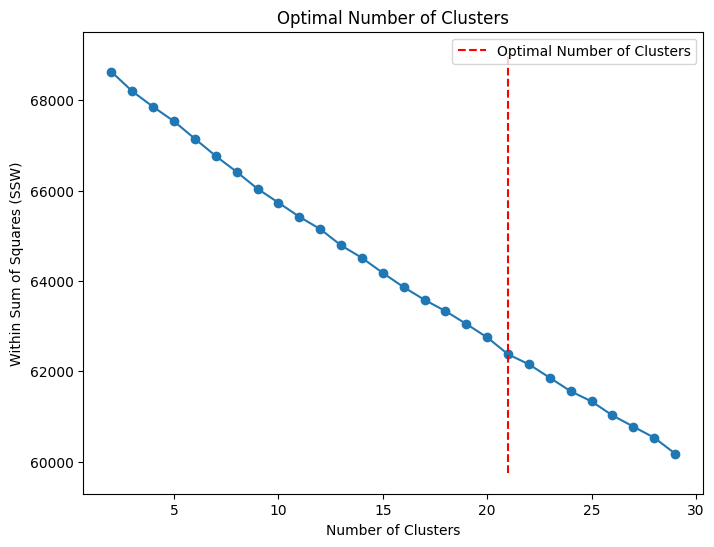

In [61]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import matplotlib.pyplot as plt

ssw = []
for k in range(2, 30):    
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(scaled_X)
    ssw.append(model.inertia_)

knee = KneeLocator(range(2, 30), ssw, curve="convex", direction="decreasing")

if knee.elbow is not None:
    optimal_num_clusters = knee.elbow
    print("Optimal number of clusters:", optimal_num_clusters)

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 30), ssw, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within Sum of Squares (SSW)')
    plt.title('Optimal Number of Clusters')
    plt.vlines(optimal_num_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label='Optimal Number of Clusters')
    plt.legend()
    plt.show()

    optimal_model = KMeans(n_clusters=optimal_num_clusters, n_init=10)
    optimal_model.fit(scaled_X)

    cluster_labels = optimal_model.labels_

else:
    print("No clear elbow point found. Consider alternative methods for determining the optimal number of clusters.")


In [76]:
elbow_point = knee.elbow
optimal_model = KMeans(n_clusters=elbow_point, n_init=10)
optimal_model.fit(scaled_X)

cluster_labels = optimal_model.predict(scaled_X)
cluster_labels



array([ 8,  8, 12, 12, 12, 12,  1, 12,  1, 18,  2,  6, 18, 18,  1,  2,  4,
       18, 18, 11, 10, 10,  2, 10, 10, 12,  2,  1,  2, 18,  0, 15, 16, 20,
        0, 20, 16, 16,  0, 20,  0, 15, 13, 15, 15, 13, 20,  5, 20, 20, 13,
       13,  5,  0,  5, 13,  5,  5, 18,  5,  2, 13,  8,  2,  8, 12, 18, 12,
       19,  8, 18,  8, 18, 18,  2, 12,  2,  9,  2,  8,  2,  2,  8,  2,  9,
        8, 18,  2, 14,  2,  8,  9, 12, 19, 19, 19,  8, 18,  1,  2,  2,  2,
       19, 10,  8,  3, 18, 12, 12,  8,  8,  4,  1,  8,  4,  8,  8, 19, 10,
       12,  3, 12,  8,  8,  6,  2,  8,  8, 12,  8, 18,  8,  8,  8,  8,  9,
       10, 12,  3,  8, 10,  3,  9, 11,  9,  2, 19,  2,  8,  9,  7, 19, 12,
        8, 12,  9, 18,  2,  2, 11,  9, 19,  7,  6,  4,  2, 11,  1,  4,  4,
       18,  9,  3, 11,  9, 11,  9,  9, 11,  6, 17, 17,  2,  4,  1,  4,  6,
        6,  6,  4, 11, 17, 11, 17, 11,  6,  6,  1, 17,  3,  6, 18,  6,  8,
        6, 11, 17,  6,  6,  6,  6, 11, 18, 17, 17, 17,  6,  6, 17,  6, 17,
       17, 17,  1, 17,  6

<h5>Model Interpretation</h5>

The best K value depends on things like how the data is spread out, how many dimensions there are, and the patterns in the data. The KneeLocator method helps us find the elbow point on the sum of squared distances curve, which shows a big change in how quickly the clusters get better (SSW). In the example, the elbow point was at K=21, suggesting a good balance between getting useful clusters and not making them too specific. Data distribution, dimensionality, etc are facors that help define these cluster choices.